In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess, cv2, json, os, sys, shutil, pyk4a, time
import numpy as np, matplotlib.pyplot as plt
from kinectacq.acquisition import start_recording
from kinectacq.paths import DATA_DIR, ensure_dir

### Set up recording location

In [3]:
import datetime

In [4]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
timestamp

'2022-02-17_10-46-53'

In [5]:
filename_prefix = DATA_DIR / 'test_recording' / timestamp

In [6]:
ensure_dir(filename_prefix)

### Get camera information

In [7]:
!k4arecorder --list

Index:0	Serial:000774310512	Color:1.6.102	Depth:1.6.75


### Set up devices
- each k4a device needs to be configured
- multi-camera rigs need to set up the WiredSyncMode
    - Master = WiredSyncMode.MASTER
    - Subordinate = WiredSyncMode.SUBORDINATE
    - subordinate_delay_off_master_usec=640 (master samples every 900usec)
- [Kinect SDK](https://microsoft.github.io/Azure-Kinect-Sensor-SDK/master/structk4a__device__configuration__t_a8208974f05d89fc1362c6a0900bdef4d.html#a8208974f05d89fc1362c6a0900bdef4d)

In [8]:
from pyk4a import (
    PyK4A,
    Config,
    ColorResolution,
    DepthMode,
    WiredSyncMode,
)

In [9]:
devices = {
    "master": {
        "id": 0,
        "pyk4a_config": {
            "color_resolution": ColorResolution.RES_720P,
            "depth_mode": DepthMode.NFOV_UNBINNED,
            #"synchronized_images_only": False,
            #"wired_sync_mode": WiredSyncMode.MASTER,
        },
        "process_kwargs": {
            "display_frames": True,
            "display_time": False,
        },
    }
}

### Set up processing functions
- Functions for reducing video file sizes to 8 bit. 

In [10]:
_dtype = np.uint16

In [11]:
def process_depth(depth):
    #return np.clip((depth - 435) * (depth < 690), 0, 255).astype(_dtype)
    return depth.astype(_dtype)
def process_ir(ir):
    #ir = np.clip(ir + 100, 160, 5500)
    #return ((np.log(ir) - 5) * 70).astype(_dtype)
    return ir.astype(_dtype)

### Recording parameters

In [12]:
ir_depth_write_frames_kwargs={
        "codec": "ffv1", #"ffv1",
        "crf": 14,
        "threads": 6,
        "fps": 30,
        "slices": 24,
        "slicecrc": 1,
        "frame_size": None,
        "get_cmd": False,
    }

In [29]:
color_write_frames_kwargs={
        "codec": "ffv1", #"h264",
        "crf": 22,
        "threads": 6,
        "fps": 30,
        "slices": 24,
        "slicecrc": 1,
        "frame_size": None,
        "get_cmd": False,
    }

In [30]:
recording_duration = 5

### Run recording

In [31]:
start_recording(
    filename_prefix,
    recording_duration,
    devices=devices,
    depth_function = process_depth,
    ir_function = process_ir,
    ir_depth_dtype = _dtype,
    save_color = True, 
    ir_depth_write_frames_kwargs=ir_depth_write_frames_kwargs,
    color_write_frames_kwargs=color_write_frames_kwargs
)

 - Frame rate =  30.33114834435833


### Read and show file

In [32]:
breakme
# wait till recording is over
#import time
#time.sleep(recording_duration)

NameError: name 'breakme' is not defined

In [35]:
filename_prefix

PosixPath('/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-02-17_10-46-53')

In [36]:
!ls /n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-02-16_17-24-33

master


In [37]:
file_loc = filename_prefix / 'master' /  "depth.avi"
vidcap = cv2.VideoCapture(file_loc.as_posix())
success,image = vidcap.read()
total_frames = vidcap.get(7)
print(total_frames, image.shape)

146.0 (576, 640, 3)


In [38]:
nbit = 16
total_expected_bits = total_frames * np.product(image.shape) * nbit
total_expected_MB_uncompressed = total_expected_bits * 1.192e-7 
print('uncompressed size: {} MB'.format(round(total_expected_MB_uncompressed)))
print('actual_size: {} MB'.format(round(os.path.getsize(file_loc) * 1e-6)))

uncompressed size: 308 MB
actual_size: 14 MB


In [39]:
# get frame at number
vidcap.set(1, 140)
success,image = vidcap.read()

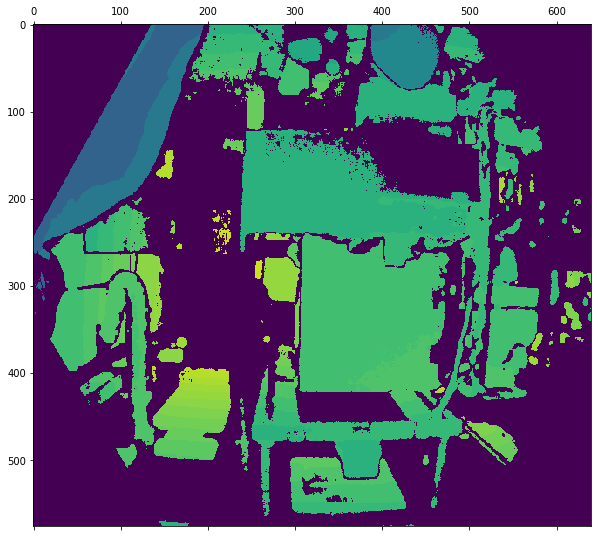

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(np.log(1+image)[:,:,0])

In [41]:
file_loc = filename_prefix / 'master' /  "color.avi"
vidcap = cv2.VideoCapture(file_loc.as_posix())
success,image = vidcap.read()
total_frames = vidcap.get(7)
print(total_frames, image.shape)

146.0 (720, 1280, 3)


In [42]:
nbit = 8
total_expected_bits = total_frames * np.product(image.shape) * nbit
total_expected_MB_uncompressed = total_expected_bits * 1.192e-7 
print('uncompressed size: {} MB'.format(total_expected_MB_uncompressed))
print('actual_size: {} MB'.format(os.path.getsize(file_loc) * 1e-6))

uncompressed size: 384.93093888 MB
actual_size: 102.098812 MB


In [43]:
success,image = vidcap.read()
# get frame at number
vidcap.set(1, 50)
success,image = vidcap.read()

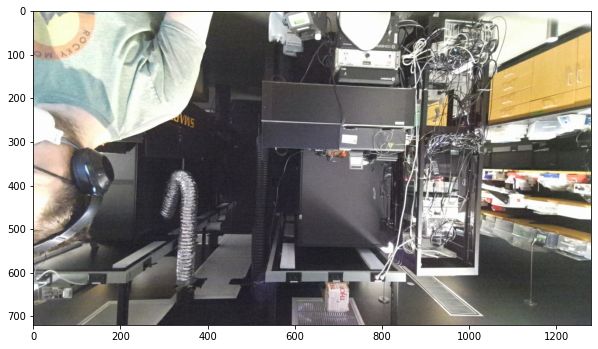

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(image)